Mengubah label dari format YOLO polygon (format .txt) menjadi citra mask biner dalam format .png

In [1]:
import os
import cv2
import numpy as np

def convert_labels_to_masks(image_dir, label_dir, output_mask_dir, image_size=(512, 512)):
    os.makedirs(output_mask_dir, exist_ok=True)

    image_files = sorted(os.listdir(image_dir))

    for image_file in image_files:
        # Ambil nama dasar tanpa ekstensi
        base_name = os.path.splitext(image_file)[0]
        label_file = os.path.join(label_dir, base_name + ".txt")
        image_path = os.path.join(image_dir, image_file)

        # Baca gambar untuk tahu ukuran aslinya
        img = cv2.imread(image_path)
        height, width = img.shape[:2]

        # Inisialisasi mask kosong
        mask = np.zeros((height, width), dtype=np.uint8)

        if os.path.exists(label_file):
            with open(label_file, "r") as f:
                line = f.readline().strip()
                parts = line.split()[1:]  # Skip class index
                coords = [float(p) for p in parts]

                # Ubah ke koordinat absolut dan buat array titik
                points = []
                for i in range(0, len(coords), 2):
                    x = int(coords[i] * width)
                    y = int(coords[i + 1] * height)
                    points.append([x, y])

                # Gambar poligon pada mask
                points_np = np.array([points], dtype=np.int32)
                cv2.fillPoly(mask, points_np, 255)  # 255 = putih (area tumor)

        # Simpan mask ke output folder
        mask_path = os.path.join(output_mask_dir, base_name + ".png")
        cv2.imwrite(mask_path, mask)

    print(f"Selesai membuat mask ke folder: {output_mask_dir}")


Mengonversi label YOLO polygon dari folder train, valid, dan test menjadi citra mask biner (segmentation mask)

In [ ]:
convert_labels_to_masks(
    image_dir="valid/images",
    label_dir="valid/labels",
    output_mask_dir="valid/masks"
)

convert_labels_to_masks(
    image_dir="train/images",
    label_dir="train/labels",
    output_mask_dir="train/masks"
)

convert_labels_to_masks(
    image_dir="test/images",
    label_dir="test/labels",
    output_mask_dir="test/masks"
)

Selesai membuat mask ke folder: train/masks
Selesai membuat mask ke folder: test/masks


Preprocessing (normalisasi, resize, augmentasi)

In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random
import cv2

class BrainTumorDataset(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=8, img_size=(256, 256), shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.image_filenames = sorted(os.listdir(self.image_dir))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.image_filenames)

    def __getitem__(self, index):
        batch_filenames = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]

        images = []
        masks = []

        for fname in batch_filenames:
            # Load and preprocess image
            img_path = os.path.join(self.image_dir, fname)
            img = load_img(img_path, target_size=self.img_size)
            img = img_to_array(img) / 255.0

            # Ganti ekstensi ke .png jika mask pakai .jpg
            mask_fname = fname.replace('.jpg', '.png')  
            mask_path = os.path.join(self.mask_dir, mask_fname)
            mask = load_img(mask_path, color_mode="grayscale", target_size=self.img_size)
            mask = img_to_array(mask) / 255.0
            mask = (mask > 0.5).astype(np.float32)  # binary mask

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

Menyiapkan Data Generator untuk Deep Learning

In [48]:
train_gen = BrainTumorDataset(
    image_dir='train/images',
    mask_dir='train/masks',
    batch_size=8,
    img_size=(256, 256)
)

val_gen = BrainTumorDataset(
    image_dir='valid/images',
    mask_dir='valid/masks',
    batch_size=8,
    img_size=(256, 256),
    shuffle=False
)

# Jika hanya ingin melakukan evaluasi performa model, maka perlu dilakukan generating pada data test
test_gen = BrainTumorDataset(
    image_dir='test/images',
    mask_dir='test/masks',
    batch_size=10,
    img_size=(256, 256),
    shuffle=False
)

Membangun Model U-Net

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Contracting path Encoder / (mengekstrak informasi penting sambil mengurangi ukuran gambar)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck / middle
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive path / decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = tf.keras.models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

Melatih Model

In [ ]:
# Menggunakan model U-Net
model = unet_model(input_size=(256, 256, 3))

# Melatih model
history = model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=20, 
    steps_per_epoch=len(train_gen), 
    validation_steps=len(val_gen)
)

Epoch 1/20


c:\Users\shoba\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


268/268 ━━━━━━━━━━━━━━━━━━━━ 2006s 7s/step - accuracy: 0.9486 - loss: 0.3622 - val_accuracy: 0.9672 - val_loss: 0.1268
Epoch 2/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 2013s 8s/step - accuracy: 0.9686 - loss: 0.1193 - val_accuracy: 0.9672 - val_loss: 0.1147
Epoch 3/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 2042s 8s/step - accuracy: 0.9689 - loss: 0.1138 - val_accuracy: 0.9695 - val_loss: 0.1078
Epoch 4/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 2051s 8s/step - accuracy: 0.9717 - loss: 0.0987 - val_accuracy: 0.9689 - val_loss: 0.1050
Epoch 5/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 1931s 7s/step - accuracy: 0.9716 - loss: 0.1006 - val_accuracy: 0.9702 - val_loss: 0.1033
Epoch 6/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 1925s 7s/step - accuracy: 0.9709 - loss: 0.1005 - val_accuracy: 0.9703 - val_loss: 0.1011
Epoch 7/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 1911s 7s/step - accuracy: 0.9730 - loss: 0.0924 - val_accuracy: 0.9747 - val_loss: 0.0870
Epoch 8/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 1930s 7s/step - accuracy: 0.9768 - loss: 0.0755 - val_accurac

EVALUASI (model unet untuk segmentasi)

Dice Coefficient

In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy

def bce_dice_loss(y_true, y_pred):
    bce = BinaryCrossentropy()(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss


In [ ]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coefficient])


In [ ]:
# Evaluasi model dengan data test
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_gen))
print(f"Dice Loss: {test_loss}")
print(f"Dice Accuracy: {test_accuracy}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9884 - loss: 0.0420
Dice Loss: 0.05258997529745102
Dice Accuracy: 0.9851104021072388


Menampilkan beberapa dataset dan hasil model

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


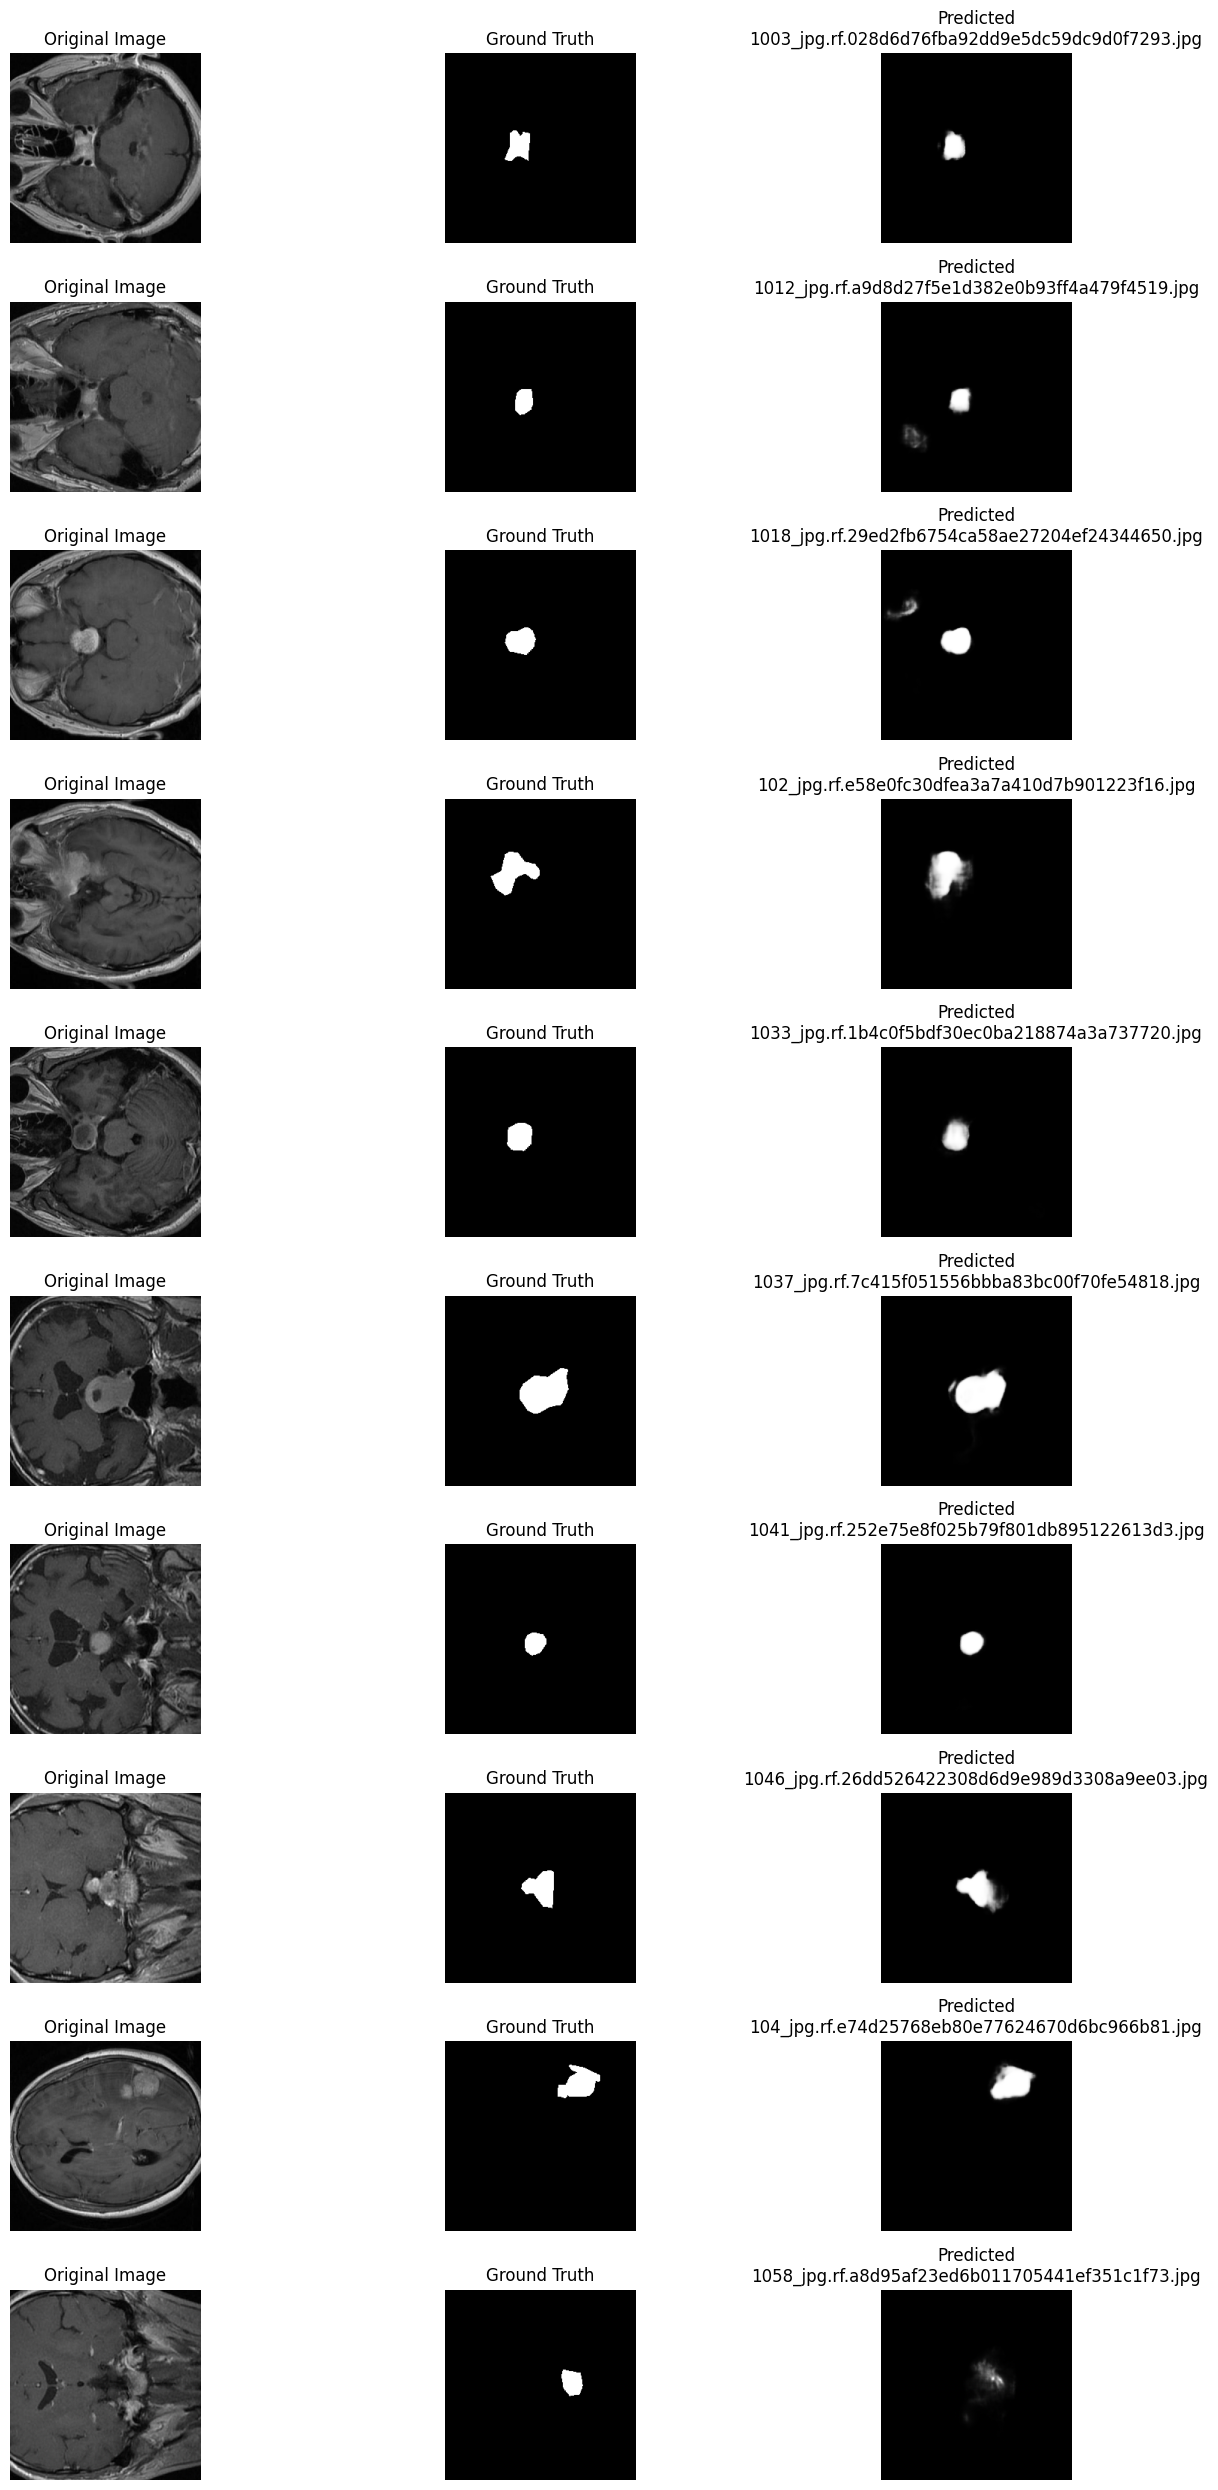

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil batch dari generator
images, masks = next(iter(test_gen))
filenames = test_gen.image_filenames[:test_gen.batch_size]

# Prediksi
preds = model.predict(images)

# Jumlah gambar yang ingin ditampilkan
n = 10
plt.figure(figsize=(15, n * 2.5))

for i in range(n):
    # Original Image
    plt.subplot(n, 3, i * 3 + 1)
    plt.imshow(images[i])
    plt.title("Original Image")
    plt.axis('off')

    # Ground Truth
    plt.subplot(n, 3, i * 3 + 2)
    plt.imshow(masks[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    # Predicted Mask
    plt.subplot(n, 3, i * 3 + 3)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title(f"Predicted\n{filenames[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Visualisasi Loss Selama Training

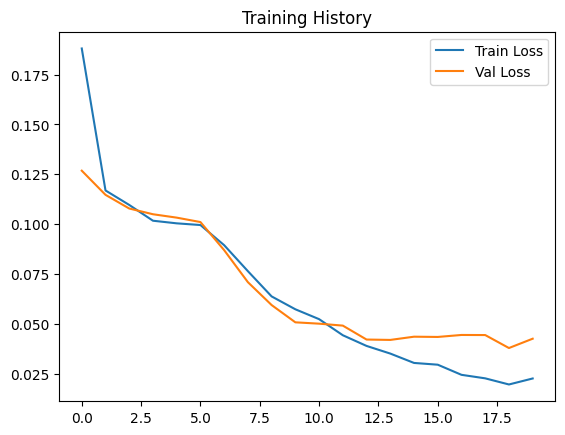

In [50]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training History")
plt.show()


Mengekstrak informasi bounding box (ROI) dari label YOLO Polygon dan menyimpannya dalam bentuk tabel .csv

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image

# Folder path
image_folder = "train/images"
mask_folder = "train/masks"
label_folder = "train/labels"

# Ekstensi yang mungkin dipakai
img_exts = ['jpg', 'jpeg', 'png']
mask_exts = ['jpg', 'jpeg', 'png']

# Helper untuk mencari file dengan ekstensi berbeda
def find_file_with_extensions(basename, folder, extensions):
    for ext in extensions:
        path = os.path.join(folder, f"{basename}.{ext}")
        if os.path.exists(path):
            return path
    return None

# Simpan hasil ke list
roi_data = []

# Iterasi semua file label
for label_file in os.listdir(label_folder):
    if not label_file.endswith(".txt"):
        continue

    basename = os.path.splitext(label_file)[0]

    # Temukan path gambar dan mask yang cocok
    image_path = find_file_with_extensions(basename, image_folder, img_exts)
    mask_path = find_file_with_extensions(basename, mask_folder, mask_exts)
    label_path = os.path.join(label_folder, label_file)

    if not image_path or not mask_path or not os.path.exists(label_path):
        print(f"Skipping {basename}, file missing.")
        continue

    # Buka gambar
    image = np.array(Image.open(image_path).convert("RGB"))

    # Buka label dan ekstrak koordinat polygon
    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = list(map(float, line.strip().split()))
        if len(parts) < 3 or len(parts) % 2 == 0:
            continue  # skip jika tidak cukup koordinat

        cls = int(parts[0])
        coords = np.array(parts[1:]).reshape(-1, 2)

        # Ubah koordinat relatif ke pixel
        h, w = image.shape[:2]
        abs_coords = np.round(coords * [w, h]).astype(int)

        # Buat bounding box ROI
        x, y, w_box, h_box = cv2.boundingRect(abs_coords)
        roi = image[y:y+h_box, x:x+w_box]

        # Simpan ke list
        roi_data.append({
            "filename": basename,
            "class": cls,
            "x": x,
            "y": y,
            "width": w_box,
            "height": h_box
        })

# Simpan ke CSV
df = pd.DataFrame(roi_data)
df.to_csv("roi_data.csv", index=False)
print("ROI data saved to roi_data.csv") 


ROI data saved to roi_data.csv


Menyimpan nama file dan label saja

In [7]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image

image_folder = "test/images"
label_folder = "test/labels"
output_folder = "cropped_rois_test"
os.makedirs(output_folder, exist_ok=True)

img_exts = ['jpg', 'jpeg', 'png']

def find_image(basename):
    for ext in img_exts:
        path = os.path.join(image_folder, f"{basename}.{ext}")
        if os.path.exists(path):
            return path
    return None

roi_data = []

for label_file in os.listdir(label_folder):
    if not label_file.endswith(".txt"):
        continue

    basename = os.path.splitext(label_file)[0]
    image_path = find_image(basename)
    if not image_path:
        print(f"Image for {basename} not found.")
        continue

    image = np.array(Image.open(image_path).convert("RGB"))
    h, w = image.shape[:2]

    with open(os.path.join(label_folder, label_file), 'r') as f:
        lines = f.readlines()

    for idx, line in enumerate(lines):
        parts = list(map(float, line.strip().split()))
        if len(parts) < 3 or len(parts) % 2 == 0:
            continue

        cls = int(parts[0])
        coords = np.array(parts[1:]).reshape(-1, 2)
        abs_coords = np.round(coords * [w, h]).astype(int)
        x, y, box_w, box_h = cv2.boundingRect(abs_coords)
        roi = image[y:y+box_h, x:x+box_w]

        roi_filename = f"{basename}_{idx}.jpg"
        cv2.imwrite(os.path.join(output_folder, roi_filename), roi)

        roi_data.append({
            "filename": roi_filename,
            "class": cls
        })

pd.DataFrame(roi_data).to_csv("roi_for_classification_test.csv", index=False)
print("ROI and labels saved.")


ROI and labels saved.


Preprocessing untuk klasifikasi ROI (Menggunakan Keras untuk preprocessing gambar dan label)

In [ ]:

import os
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Konfigurasi dasar
IMG_SIZE = (128, 128)  # ubah sesuai kebutuhan
DATA_DIR = 'cropped_rois'  # folder tempat ROI hasil ekstraksi disimpan
CSV_PATH = 'roi_for_classification.csv'  # labelnya

# Load CSV berisi nama file dan label
labels_df = pd.read_csv(CSV_PATH)

# Preprocessing gambar
X = []
y = []

for _, row in labels_df.iterrows():
    img_path = os.path.join(DATA_DIR, row['filename'])
    if os.path.exists(img_path):
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img) / 255.0  # Normalisasi
        X.append(img)
        y.append(row['class'])

X = np.array(X)
y = np.array(y)

# One-hot encode label (jika lebih dari 2 kelas)
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes=num_classes)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)

print("Preprocessing selesai. Jumlah data training:", len(X_train), "dan validasi:", len(X_val))



Preprocessing selesai. Jumlah data training: 1715 dan validasi: 429


c:\Users\shoba\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 305ms/step - accuracy: 0.4721 - loss: 1.0649 - val_accuracy: 0.5781 - val_loss: 0.9004
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - accuracy: 0.6197 - loss: 0.8503 - val_accuracy: 0.6270 - val_loss: 0.7538
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 251ms/step - accuracy: 0.6383 - loss: 0.7386 - val_accuracy: 0.6946 - val_loss: 0.6982
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - accuracy: 0.6813 - loss: 0.6793 - val_accuracy: 0.7179 - val_loss: 0.6601
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 257ms/step - accuracy: 0.6917 - loss: 0.6402 - val_accuracy: 0.6993 - val_loss: 0.6537
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 259ms/step - accuracy: 0.7281 - loss: 0.5722 - val_accuracy: 0.7599 - val_loss: 0.5972
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 248ms/step - accuracy: 0.7671 - loss: 0.5628 - val_accuracy: 0.7646 - val_loss: 0.5626
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 269ms/step - accuracy: 0.7934 - loss: 0.5059 - val_accu

Membangun model mobilenet v2

In [ ]:
import tensorflow as tf
import pandas as pd
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Ukuran gambar dan batch
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Path folder dan CSV label
train_img_dir = 'cropped_rois'        
val_img_dir = 'cropped_rois_val'            
test_img_dir = 'cropped_rois_test'          

train_csv = 'roi_for_classification_train.csv'
val_csv = 'roi_for_classification_val.csv'
test_csv = 'roi_for_classification_test.csv'


# load csv dan prepare dataset

# Fungsi untuk buat dataset dari csv
def create_dataset(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    image_paths = [os.path.join(img_dir, fname) for fname in df['filename']]
    labels = df['class'].astype('int').values
    return image_paths, labels

# Buat dataset dari train, val, test
train_paths, train_labels = create_dataset(train_csv, train_img_dir)
val_paths, val_labels = create_dataset(val_csv, val_img_dir)
test_paths, test_labels = create_dataset(test_csv, test_img_dir)

# Tentukan jumlah kelas
num_classes = len(set(train_labels))


# data pipeline dengan tf.data

# Fungsi pemrosesan gambar dan label
def load_and_preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalisasi
    label = tf.one_hot(label, depth=num_classes)
    return image, label

# Fungsi membuat dataset tf.data
def prepare_dataset(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# Buat dataset final
train_ds = prepare_dataset(train_paths, train_labels)
val_ds = prepare_dataset(val_paths, val_labels)
test_ds = prepare_dataset(test_paths, test_labels)


# bangun model transfer learning

# Pakai MobileNetV2 sebagai feature extractor
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pretrained layers

# Tambah classifier di atas feature extractor
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Buat model akhir
model = Model(inputs=base_model.input, outputs=output)

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# training model

model.fit(train_ds, validation_data=val_ds, epochs=10)

# evaluasi model dengan data test

loss, acc = model.evaluate(test_ds)
print(f"\nAkurasi pada data test: {acc:.4f}")


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 54s 734ms/step - accuracy: 0.4888 - loss: 1.2952 - val_accuracy: 0.6846 - val_loss: 0.7310
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 48s 717ms/step - accuracy: 0.6968 - loss: 0.7614 - val_accuracy: 0.7386 - val_loss: 0.6152
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 46s 689ms/step - accuracy: 0.7540 - loss: 0.6311 - val_accuracy: 0.7941 - val_loss: 0.5446
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 47s 676ms/step - accuracy: 0.7656 - loss: 0.5644 - val_accuracy: 0.8121 - val_loss: 0.5008
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 608ms/step - accuracy: 0.7883 - loss: 0.5318 - val_accuracy: 0.8137 - val_loss: 0.4687
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 35s 521ms/step - accuracy: 0.7964 - loss: 0.5098 - val_accuracy: 0.8203 - val_loss: 0.4786
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 35s 520ms/step - accuracy: 0.8051 - loss: 0.4967 - val_accuracy: 0.8056 - val_loss: 0.5173
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 35s 528ms/step - accuracy: 0.7918 - loss: 0.4978 - val_accu

Menyimpan model

In [10]:
model.save('model_ku.h5') 

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# parameter

IMG_SIZE = (224, 224)  # Sesuai dengan input training
CLASS_NAMES = ['glioma', 'meningioma', 'pituitary'] # nama kelas

# fungsi inference

def load_and_preprocess_image(img_path):
    """Membaca dan memproses gambar."""
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def predict_image(img_path, model):
    """Melakukan prediksi pada gambar yang diberikan path-nya."""
    image = load_and_preprocess_image(img_path)
    image = tf.expand_dims(image, axis=0)  # Tambahkan batch dimensi

    predictions = model.predict(image)
    predicted_class = tf.argmax(predictions[0]).numpy()
    confidence = tf.reduce_max(predictions[0]).numpy()

    # Visualisasi hasil
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f'Predicted: {CLASS_NAMES[predicted_class]} ({confidence*100:.2f}%)')
    plt.show()

    return CLASS_NAMES[predicted_class], confidence


Melakukan prediksi dari hasil model

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


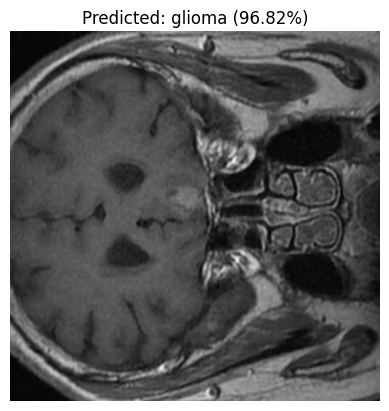

Hasil Prediksi: glioma dengan keyakinan 0.97


In [ ]:
# model yang sudah dilatih dan disimpan
model = tf.keras.models.load_model('model_ku.h5') 

# Jalankan prediksi
img_path = 'test/images/1573_jpg.rf.c0e0d5f3655f6599102567826357a165.jpg'  # Ganti sesuai gambar yang ingin diuji
label, conf = predict_image(img_path, model)

print(f'Hasil Prediksi: {label} dengan keyakinan {conf:.2f}')
